In [1]:
# MTREND

In [1]:
import datetime as dt

import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
import plotly.graph_objects as go
import polars as pl
from dash import Dash, dcc, html
from plotly.subplots import make_subplots

nse = mcal.get_calendar("NSE")

In [2]:
pd.set_option("display.max_rows", 25_000)
pd.set_option("display.max_columns", 500)
pl.Config.set_tbl_cols(500)
pl.Config.set_tbl_rows(10_000)

pd.options.display.float_format = "{:.4f}".format

In [3]:
import sys

sys.path.append("..")
from tooling.enums import AssetClass, Index, Spot, StrikeSpread
from tooling.fetch import fetch_option_data, fetch_spot_data
from tooling.filter import find_atm, option_tool

In [4]:
def get_expiry(f_today):
    days_to_thursday = (3 - f_today.weekday()) % 7
    nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
    f_expiry = nearest_thursday
    if nse.valid_days(start_date=nearest_thursday, end_date=nearest_thursday).empty:
        f_expiry = nearest_thursday - dt.timedelta(days=1)
    return f_expiry


def get_option_contract_name(symbol, strike, expiry, opt_type):
    temp = "0"
    mth = expiry.month

    if (expiry + dt.timedelta(days=7)).month != expiry.month:
        date_string = expiry.strftime("%y%b").upper()
        return f"{symbol}{date_string}{strike}{opt_type}"
    else:
        if expiry.day <= 9:
            date_string = f"{expiry.year - 2000}{mth}{temp}{expiry.day}"
        else:
            date_string = f"{expiry.year - 2000}{mth}{expiry.day}"
        return f"{symbol}{date_string}{strike}{opt_type}"

In [5]:
bnf_pandas = pd.read_csv("../data/bnf_min.csv")
# bnf_pandas = pd.read_csv("../data/fnf_1hr_tv.csv")
# bnf_pandas = pd.read_csv('../data/midcp_select_1hr_tv (4).csv')
# bnf_pandas = pd.read_csv('../data/sensex_1hr_tv.csv')
# bnf_pandas = pd.read_csv('../data/crude_4hr_tv.csv')
# bnf_pandas = pd.read_csv('../data/gold_4hr_tv.csv')

In [8]:
bnf_pandas.head(20)

datetime       open       high        low      close  \
0   2017-01-02T09:15:00.000000 18242.3000 18248.2000 18175.9000 18181.2000   
1   2017-01-02T09:16:00.000000 18181.8500 18194.7000 18179.9500 18184.4500   
2   2017-01-02T09:17:00.000000 18184.9500 18189.2500 18133.8000 18133.8000   
3   2017-01-02T09:18:00.000000 18135.1000 18141.5500 18118.5500 18138.9500   
4   2017-01-02T09:19:00.000000 18138.9500 18142.5500 18120.4500 18124.3000   
5   2017-01-02T09:20:00.000000 18123.9500 18123.9500 18100.3000 18100.3000   
6   2017-01-02T09:21:00.000000 18101.6500 18112.1500 18091.4500 18112.1000   
7   2017-01-02T09:22:00.000000 18114.3500 18116.2000 18091.6500 18101.6000   
8   2017-01-02T09:23:00.000000 18103.6500 18115.1000 18094.8000 18102.9000   
9   2017-01-02T09:24:00.000000 18102.4500 18102.9000 18089.3500 18093.0500   
10  2017-01-02T09:25:00.000000 18093.5000 18101.1000 18090.2500 18097.2500   
11  2017-01-02T09:26:00.000000 18098.2500 18099.3000 18088.6500 18098.1000   
12  2017-01-02T09:27:00.000000 18099.1500 18101.7000 18089.8000 18090.9000   
13  2017-01-02T09:28:00.000000 18091.0000 18092.6500 18076.9500 18077.1500   
14  2017-01-02T09:29:00.000000 18074.2000 18074.7500 18052.1500 18052.1500   
15  2017-01-02T09:30:00.000000 18051.2500 18051.4500 18024.2000 18024.2000   
16  2017-01-02T09:31:00.000000 18025.2500 18027.8000 17999.9000 17999.9000   
17  2017-01-02T09:32:00.000000 18000.1500 18021.0500 17995.4000 18018.8500   
18  2017-01-02T09:33:00.000000 18019.0500 18021.3000 18012.0000 18019.4500   
19  2017-01-02T09:34:00.000000 18018.4500 18041.9500 18018.4500 18041.9500   

    volume  
0        0  
1        0  
2        0  
3        0  
4        0  
5        0  
6        0  
7        0  
8        0  
9        0  
10       0  
11       0  
12       0  
13       0  
14       0  
15       0  
16       0  
17       0  
18       0  
19       0

In [9]:
# If Stocks Data ...
bnf_pandas["datetime"] = pd.to_datetime(bnf_pandas["datetime"])
bnf_pandas["datetime"] = bnf_pandas["datetime"].dt.tz_localize(None)
bnf_pandas = bnf_pandas[bnf_pandas["datetime"].dt.year >= 2017]
# bnf_pandas.drop(columns=["time"], inplace=True)
# bnf_pandas

In [10]:
bnf = pl.DataFrame(bnf_pandas)
print(type(bnf))
# bnf

<class 'polars.dataframe.frame.DataFrame'>


In [171]:
# # For crude oil Data
# bnf1 = pd.DataFrame(bnf_pandas)
# bnf1 = bnf1.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
# bnf1['datetime'] = pd.to_datetime(bnf1['datetime'])
# bnf1['index'] = bnf1['datetime']
# bnf1.rename(columns={'o': 'open', 'h': 'high', 'l': 'low', 'c': 'close'}, inplace=True)
# bnf = pl.DataFrame(bnf1)
# print(type(bnf))
# bnf

In [11]:
# bnf['datetime'] = pd.to_datetime(bnf['datetime'])
# bnf = bnf.drop(columns=['Unnamed: 0'])
# bnf.set_index(bnf['datetime'], inplace=True)
# bnf
# bnf = bnf.with_columns(pl.col('datetime').str.to_datetime(format='%Y-%m-%dT%H:%M:%S.%f'))
# print(bnf)
# bnf = bnf.with_columns(pl.col('datetime').cast(pl.DateTime))

# Set 'datetime' column as index
bnf = bnf.with_columns([pl.col("datetime").alias("index")]).drop("datetime")

# Now 'datetime' is set as the index
# bnf

In [12]:
bnf = bnf.with_columns(pl.col("index").alias("datetime"))
# bnf

In [174]:
# bnf

In [175]:
def resample(
    data: pl.DataFrame, timeframe, offset: dt.timedelta | None = None
) -> pl.DataFrame:
    return (
        data.set_sorted("datetime")
        .group_by_dynamic(
            index_column="datetime",
            every=timeframe,
            period=timeframe,
            truncate=True,
            offset=offset,
        )
        .agg(
            [
                pl.col("open").first().alias("open"),
                pl.col("high").max().alias("high"),
                pl.col("low").min().alias("low"),
                pl.col("close").last().alias("close"),
                pl.col("volume").sum().alias("volume"),
            ]
        )
    )

ohlc_resampled = resample(bnf, '60m', pd.Timedelta(minutes=15))

# bnf_1hr = ohlc_15min
bnf_1hr = ohlc_resampled
bnf_final = bnf_1hr.to_pandas()
bnf_final['datetime'] = pd.to_datetime(bnf_final['datetime'])
# bnf_final
# bnf_1hr

In [176]:
# bnf_final = bnf
# bnf_final

In [177]:
# # bnf_final = bnf_1hr
# bnf_final['datetime'] = pd.to_datetime(bnf_final['datetime'])
# bnf_final

In [13]:
def generate_signals1(df):
    df["close"] = pd.to_numeric(df["close"], errors="coerce")
    df["MA20"] = df["close"].rolling(window=9).mean()
    df["MA10"] = df["close"].rolling(window=30).mean()

    df["Buy_Signal"] = 0

    # Generate signals using boolean masking
    buy_signal_mask = (
        (df["MA20"] > df["MA20"].shift(1))
        # & (df["MA20"].shift(1) > df["MA20"].shift(2))
        # & (df['MA20'].shift(2) > df['MA20'].shift(3))
        # & (df['MA20'].shift(3) > df['MA20'].shift(4))
        # & (df['MA20'].shift(4) > df['MA20'].shift(5))
    )

    df.loc[buy_signal_mask, "Buy_Signal"] = 1

    return df

In [14]:
def generate_signals2(df):
    df["close"] = pd.to_numeric(df["close"], errors="coerce")
    df["MA20"] = df["close"].rolling(window=50).mean()
    df["MA10"] = df["close"].rolling(window=49).mean()

    df["Sell_Signal"] = 0

    # Generate signals using boolean masking
    sell_signal_mask = (
        (df["MA20"] < df["MA20"].shift(1))
        & (df["MA20"].shift(1) < df["MA20"].shift(2))
        & (df["MA20"].shift(2) < df["MA20"].shift(3))
        & (df["MA20"].shift(3) < df["MA20"].shift(4))
        & (df["MA20"].shift(4) < df["MA20"].shift(5))
        # & (df['MA20'].shift(5) < df['MA20'].shift(6))
        # & (df['MA20'].shift(6) < df['MA20'].shift(7))
    )

    df.loc[sell_signal_mask, "Sell_Signal"] = 1

    return df

In [15]:
bnf1 = bnf
bnf2 = bnf

In [16]:
bnf1 = bnf1.to_pandas()
bnf2 = bnf2.to_pandas()
signals_df1 = generate_signals1(bnf1)
signals_df2 = generate_signals2(bnf2)

In [17]:
signals_df1 = signals_df1.rename(
    columns={"open": "o", "high": "h", "low": "l", "close": "c"}
)
signals_df2 = signals_df2.rename(
    columns={"open": "o", "high": "h", "low": "l", "close": "c"}
)

In [1134]:
# Positional

def execute(df):

    trade_book = []
    in_trade = False
    signal_entry_price = 100000
    signal_initial_sl = 0
    already_signal_exists = False
    is_trailing_active = False
    remark = ""
    portfolio_value = 2500000

    for i in range(1, len(df)):
        points = 0
        current_candle_open = df.iloc[i]["o"]
        current_candle_high = df.iloc[i]["h"]
        current_candle_low = df.iloc[i]["l"]
        current_candle_close = df.iloc[i]["c"]
        current_moving_average_price = df.iloc[i]["MA10"]

        if not in_trade:
            if df.iloc[i]["Buy_Signal"] == 1:
                if not already_signal_exists:
                    # Fresh Buy Signal
                    # print(df.iloc[i])
                    # print('Fresh Buy Signal')
                    signal_entry_price = current_candle_high
                    signal_initial_sl = current_candle_low
                    signal_creation_time = df.iloc[i]["datetime"]
                    already_signal_exists = True

                    # if (signal_entry_price - signal_initial_sl > 400):
                    #     # Skip Signal Candle Due To Big Size
                    #     already_signal_exists = False
                    #     signal_entry_price = 100000
                    #     signal_initial_sl = 0

                else:
                    if current_candle_open > signal_entry_price:
                        # Gap Up Open, SKIP trade
                        # print(df.iloc[i])
                        # print('Gap Up Open, Skip Trade')
                        already_signal_exists = False
                        signal_entry_price = 100000
                        signal_initial_sl = 0
                    elif current_candle_high < signal_entry_price:
                        # Better Candle
                        # print(df.iloc[i])
                        # print('Better Candle')
                        signal_entry_price = current_candle_high
                        signal_initial_sl = current_candle_low
                        signal_creation_time = df.iloc[i]["datetime"]

                        # if (signal_entry_price - signal_initial_sl > 400):
                        #     # Skip Signal Candle Due To Big Size
                        #     already_signal_exists = False
                        #     signal_entry_price = 100000
                        #     signal_initial_sl = 0

                    elif current_candle_high > signal_entry_price:
                        # Entry Triggered
                        # print(df.iloc[i])
                        # print('Entry Triggered')
                        in_trade = True
                        entry_time = df.iloc[i]["datetime"]
                        entry_price = signal_entry_price
                        points = 0
            else:
                if df.iloc[i - 1]["Buy_Signal"] == 1:
                    # Considering the forward bias condition as well now
                    signal_entry_price = df.iloc[i - 1]["h"]
                    signal_initial_sl = df.iloc[i - 1]["l"]
                    signal_creation_time = df.iloc[i - 1]["datetime"]
                    already_signal_exists = True

                    if current_candle_high > signal_entry_price:
                        in_trade = True
                        entry_time = df.iloc[i]["datetime"]
                        entry_price = signal_entry_price
                        points = 0
                    else:
                        # Discard Existing Signal
                        already_signal_exists = False
                        signal_entry_price = 100000
                        signal_initial_sl = 0

        if in_trade:
            trade_entry_price = signal_entry_price
            trade_initial_sl = signal_initial_sl
            trade_final_sl = signal_initial_sl

            if (
                not is_trailing_active
                and current_candle_low > current_moving_average_price
            ):
                is_trailing_active = True

            if not is_trailing_active:
                if current_candle_open < trade_initial_sl:
                    # if df.iloc[i-1]['l'] < trade_initial_sl:
                    #     #Previous Candle Already Hit the SL Hence don't check gap down
                    #     print(df.iloc[i])
                    #     print('Initial SL Hit Before Gap Down')
                    #     in_trade = False
                    #     points = trade_initial_sl - trade_entry_price
                    #     exit_price = trade_initial_sl
                    #     exit_time = df.iloc[i-1]['datetime']
                    #     remark = 'Initial SL Hit Before Gap Down'
                    # else:
                    if (
                        df.iloc[i]["datetime"].date() == entry_time.date()
                        and df.iloc[i]["datetime"].time() == entry_time.time()
                    ):
                        if current_candle_close <= trade_initial_sl:
                            in_trade = False
                            points = trade_initial_sl - trade_entry_price
                            exit_price = trade_initial_sl
                            exit_time = df.iloc[i]["datetime"]
                            remark = "Initial SL hit"

                    else:
                        # Gap Open Outside ISL
                        # print(df.iloc[i])
                        # print('Gap Open Outside ISL')
                        in_trade = False
                        points = current_candle_open - trade_entry_price
                        exit_price = current_candle_open
                        exit_time = df.iloc[i]["datetime"]
                        remark = "Gap Open Outside ISL"

                elif current_candle_low <= trade_initial_sl:
                    # Initial SL Hit
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = trade_initial_sl - trade_entry_price
                    exit_price = trade_initial_sl
                    exit_time = df.iloc[i]["datetime"]
                    remark = "Initial SL Hit"

            else:
                trade_final_sl = max(trade_initial_sl, current_moving_average_price)

                if current_candle_open <= trade_initial_sl:
                    # if df.iloc[i-1]['l'] < trade_initial_sl:
                    #     #Previous Candle Already Hit the SL Hence don't check gap down
                    #     print(df.iloc[i])
                    #     print('Initial SL Hit Before Gap Down')
                    #     in_trade = False
                    #     points = trade_initial_sl - trade_entry_price
                    #     exit_price = trade_initial_sl
                    #     exit_time = df.iloc[i-1]['datetime']
                    #     remark = 'Initial SL Hit'
                    # else:
                    if (
                        df.iloc[i]["datetime"].date() == entry_time.date()
                        and df.iloc[i]["datetime"].time() == entry_time.time()
                    ):
                        if current_candle_close <= trade_initial_sl:
                            in_trade = False
                            points = trade_initial_sl - trade_entry_price
                            exit_price = trade_initial_sl
                            exit_time = df.iloc[i]["datetime"]
                            remark = "Initial SL hit"

                    else:
                        # Gap Open Outside ISL
                        # print(df.iloc[i])
                        # print('Gap Open Outside ISL')
                        in_trade = False
                        points = current_candle_open - trade_entry_price
                        exit_price = current_candle_open
                        exit_time = df.iloc[i]["datetime"]
                        remark = "Gap Open Outside ISL"

                elif current_candle_low <= trade_initial_sl:
                    # if trade_initial_sl >= current_moving_average_price:
                    # Despite Trailing, Initial SL hit
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = trade_initial_sl - trade_entry_price
                    exit_price = trade_initial_sl
                    exit_time = df.iloc[i]["datetime"]
                    remark = "Initial SL hit"

                elif current_candle_close <= trade_final_sl:
                    # Price Closed below TSL i.e. MA10 , TSL Hit
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = current_candle_close - trade_entry_price
                    exit_price = current_candle_close
                    exit_time = df.iloc[i]["datetime"]
                    is_trailing_active = False
                    remark = "TSL Hit"

            if points:
                qty = int(round(portfolio_value * 5 / entry_price / 40)) * 40
                slippage = 0.0002 * (entry_price + exit_price)
                # slippage = 10
                final_points = points - slippage
                # final_points = points
                trade = {
                    "Signal Generated At": signal_creation_time,
                    "Trade Type": "LONG",
                    "Entry Time": entry_time,
                    "Entry Price": entry_price,
                    "Initial SL": trade_initial_sl,
                    "Final SL": trade_final_sl,
                    "Exit Time": exit_time,
                    "Exit Price": exit_price,
                    "Points Captured": points,
                    "After Costs": final_points,
                    "PnL": final_points * qty,
                    "Remarks": remark,
                    "Qty": qty,
                    "Leverage": "5x",
                    "ROI%": (final_points * qty / portfolio_value) * 100,
                    "Trade Year": entry_time.year,
                    "Trade Month": entry_time.month,
                }
                trade_book.append(trade)
                points = 0
                in_trade = False
                already_signal_exists = False
                remark = ""
                is_trailing_active = False

    trade_book_df = pd.DataFrame(trade_book)
    return trade_book_df

In [1135]:
new_tb = execute(signals_df1)
new_tb["DD%"] = new_tb["ROI%"].cumsum() - new_tb["ROI%"].cumsum().cummax()
tradebook_buy_side = new_tb
# new_tb

In [1136]:
# tradebook_buy_side['DD%'] = (tradebook_buy_side['ROI%'].cumsum() - tradebook_buy_side['ROI%'].cumsum().cummax())
# tradebook_buy_side

In [1137]:
# new_tb

In [1138]:
stats_df5 = pd.DataFrame(
    index=range(2017, 2025),
    columns=[
        "Total ROI",
        "Total Trades",
        "Win Rate",
        "Avg Profit% per Trade",
        "Avg Loss% per Trade",
        "Max Drawdown",
        "ROI/DD Ratio",
    ],
)

# Iterate over each year
for year in range(2017, 2025):
    # Filter trades for the current year
    year_trades = new_tb[(new_tb["Trade Year"] == year)]

    # Calculate total ROI
    total_roi = year_trades["ROI%"].sum()

    # Calculate total number of trades
    total_trades = len(year_trades)

    # Calculate win rate
    win_rate = (year_trades["ROI%"] > 0).mean() * 100

    # Calculate average profit per trade
    avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()

    # Calculate average loss per trade
    avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()

    # Calculate maximum drawdown
    max_drawdown = (
        year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
    ).min()

    # Calculate ROI/DD ratio
    roi_dd_ratio = total_roi / abs(max_drawdown)

    # Store the statistics in the DataFrame
    stats_df5.loc[year] = [
        total_roi,
        total_trades,
        win_rate,
        avg_profit,
        avg_loss,
        max_drawdown,
        roi_dd_ratio,
    ]

# Calculate overall statistics
overall_total_roi = stats_df5["Total ROI"].sum()
overall_total_trades = stats_df5["Total Trades"].sum()
overall_win_rate = (new_tb["ROI%"] > 0).mean() * 100
overall_avg_profit = new_tb[new_tb["ROI%"] > 0]["ROI%"].mean()
overall_avg_loss = new_tb[new_tb["ROI%"] < 0]["ROI%"].mean()
overall_max_drawdown = (
    new_tb["ROI%"].cumsum() - new_tb["ROI%"].cumsum().cummax()
).min()
overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)

# Store the overall statistics in the DataFrame
stats_df5.loc["Overall"] = [
    overall_total_roi,
    overall_total_trades,
    overall_win_rate,
    overall_avg_profit,
    overall_avg_loss,
    overall_max_drawdown,
    overall_roi_dd_ratio,
]
stats_df5

Total ROI Total Trades Win Rate Avg Profit% per Trade  \
2017      38.1389           89  19.1011                8.7624   
2018      72.3787           61  32.7869                8.1637   
2019      87.8372           76  25.0000               10.1303   
2020     136.3116           66  25.7576               19.0677   
2021      94.9717           68  32.3529                9.4119   
2022       6.4922           68  25.0000                8.2782   
2023      41.3119           68  17.6471               10.4304   
2024     -35.7647           43  16.2791                5.8802   
Overall  441.6775     539.0000  24.3043               10.2517   

        Avg Loss% per Trade Max Drawdown ROI/DD Ratio  
2017                -1.5392     -28.7479       1.3267  
2018                -2.2169     -34.0893       2.1232  
2019                -1.8358     -32.9241       2.6679  
2020                -3.8334     -57.7158       2.3618  
2021                -2.4367     -37.8697       2.5079  
2022                -2.6321     -53.8627       0.1205  
2023                -1.4974     -21.0397       1.9635  
2024                -2.1368     -37.5659      -0.9521  
Overall             -2.2091     -61.5485       7.1761

In [1098]:
# tradebook_buy_side['After Costs'].sum()
# tradebook_buy_side.loc[tradebook_buy_side["Trade Year"] < 2024, "ROI%"].sum()

In [465]:
# tradebook_buy_side.to_csv("FNF_Long_Only_MTrend_5X_Lev_80_1_80.csv")
# tradebook_buy_side.to_csv("MIDCP_Long_Only_MTrend_5xLev_9_1_68.csv")

In [149]:
# 9 (Signal MA) , 68 (Trailing MA) , 1 (No. of Candles) : MIDCP -> Buy Best Variation
# 0.05% of Entry + Exit -> Slippage , 5x leverage

In [151]:
# Positional Sell Side


def execute_sell_side(df):
    portfolio_value = 2500000
    trade_book = []
    in_trade = False
    signal_entry_price = 100000
    signal_initial_sl = 0
    already_signal_exists = False
    remark = ""
    is_trailing_active = False

    for i in range(1, len(df)):
        points = 0
        current_candle_open = df.iloc[i]["o"]
        current_candle_high = df.iloc[i]["h"]
        current_candle_low = df.iloc[i]["l"]
        current_candle_close = df.iloc[i]["c"]
        current_moving_average_price = df.iloc[i]["MA10"]

        if not in_trade:
            if df.iloc[i]["Sell_Signal"] == 1:
                if not already_signal_exists:
                    # Fresh Sell Signal
                    # print(df.iloc[i])
                    # print('Fresh Short Sell Signal')
                    signal_entry_price = current_candle_low
                    signal_initial_sl = current_candle_high
                    signal_creation_time = df.iloc[i]["datetime"]
                    already_signal_exists = True

                    # if (signal_initial_sl - signal_entry_price > 400):
                    #     # Skip Signal Candle Due To Big Size
                    #     already_signal_exists = False
                    #     signal_entry_price = 100000
                    #     signal_initial_sl = 0

                else:
                    if current_candle_open < signal_entry_price:
                        # Gap Down Outside, SKIP trade
                        # print(df.iloc[i])
                        # print('Gap Outside, Skip Trade')
                        already_signal_exists = False
                        signal_entry_price = 100000
                        signal_initial_sl = 0
                    elif current_candle_low > signal_entry_price:
                        # Better Candle
                        # print(df.iloc[i])
                        # print('Better Candle')
                        signal_entry_price = current_candle_low
                        signal_initial_sl = current_candle_high
                        signal_creation_time = df.iloc[i]["datetime"]

                        # if (signal_initial_sl - signal_entry_price > 400):
                        #     # Skip Signal Candle Due To Big Size
                        #     already_signal_exists = False
                        #     signal_entry_price = 100000
                        #     signal_initial_sl = 0

                    elif current_candle_low < signal_entry_price:
                        # Entry Triggered
                        # print(df.iloc[i])
                        # print('Entry Triggered')
                        in_trade = True
                        entry_time = df.iloc[i]["datetime"]
                        entry_price = signal_entry_price
                        points = 0
            else:
                if df.iloc[i - 1]["Sell_Signal"] == 1:
                    # Considering the forward bias condition as well now
                    signal_entry_price = df.iloc[i - 1]["l"]
                    signal_initial_sl = df.iloc[i - 1]["h"]
                    signal_creation_time = df.iloc[i - 1]["datetime"]
                    already_signal_exists = True

                    if current_candle_low < signal_entry_price:
                        in_trade = True
                        entry_time = df.iloc[i]["datetime"]
                        entry_price = signal_entry_price
                        points = 0
                    else:
                        # Discard Existing Signal
                        already_signal_exists = False
                        signal_entry_price = 100000
                        signal_initial_sl = 0

        if in_trade:
            trade_entry_price = signal_entry_price
            trade_initial_sl = signal_initial_sl
            trade_final_sl = signal_initial_sl

            if (
                not is_trailing_active
                and current_candle_high < current_moving_average_price
            ):
                is_trailing_active = True

            if not is_trailing_active:
                if current_candle_open > trade_initial_sl:
                    # if df.iloc[i-1]['h'] > trade_initial_sl:
                    #     #Previous Candle Already Hit the SL Hence don't check gap down
                    #     in_trade = False
                    #     points = -1 * (trade_initial_sl - trade_entry_price)
                    #     exit_price = trade_initial_sl
                    #     exit_time = df.iloc[i-1]['datetime']
                    #     remark = 'Initial SL Hit'
                    # else:
                    if (
                        df.iloc[i]["datetime"].date() == entry_time.date()
                        and df.iloc[i]["datetime"].time() == entry_time.time()
                    ):
                        # continue
                        if current_candle_close >= trade_initial_sl:
                            in_trade = False
                            points = -1 * (trade_initial_sl - trade_entry_price)
                            exit_price = trade_initial_sl
                            exit_time = df.iloc[i]["datetime"]
                            remark = "Initial SL Hit"
                    else:
                        # Gap Open Outside ISL
                        # print(df.iloc[i])
                        # print('Gap Outside Initial SL')
                        in_trade = False
                        points = trade_entry_price - current_candle_open
                        exit_price = current_candle_open
                        exit_time = df.iloc[i]["datetime"]
                        remark = "Gap Open Outside ISL"

                elif current_candle_high >= trade_initial_sl:
                    # Initial SL Hit
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = -1 * (trade_initial_sl - trade_entry_price)
                    exit_price = trade_initial_sl
                    exit_time = df.iloc[i]["datetime"]
                    remark = "Initial SL Hit"

                elif current_candle_close >= trade_final_sl:
                    # TSL Hit
                    # print(df.iloc[i])
                    # print('TSL Hit')
                    in_trade = False
                    points = -1 * (current_candle_close - trade_entry_price)
                    exit_price = current_candle_close
                    exit_time = df.iloc[i]["datetime"]
                    remark = "TSL Hit"

            elif is_trailing_active:
                trade_final_sl = min(trade_initial_sl, current_moving_average_price)

                if current_candle_open > trade_initial_sl:
                    # if df.iloc[i-1]['h'] > trade_initial_sl:
                    #     #Previous Candle Already Hit the SL Hence don't check gap down
                    #     in_trade = False
                    #     points = -1 * (trade_initial_sl - trade_entry_price)
                    #     exit_price = trade_initial_sl
                    #     exit_time = df.iloc[i-1]['datetime']
                    #     remark = 'Initial SL Hit'
                    # else:
                    if (
                        df.iloc[i]["datetime"].date() == entry_time.date()
                        and df.iloc[i]["datetime"].time() == entry_time.time()
                    ):
                        # continue
                        if current_candle_close >= trade_initial_sl:
                            in_trade = False
                            points = -1 * (trade_initial_sl - trade_entry_price)
                            exit_price = trade_initial_sl
                            exit_time = df.iloc[i]["datetime"]
                            remark = "Initial SL Hit"
                    else:
                        # Gap Open Outside ISL
                        # print(df.iloc[i])
                        # print('Gap Outside Initial SL')
                        in_trade = False
                        points = trade_entry_price - current_candle_open
                        exit_price = current_candle_open
                        exit_time = df.iloc[i]["datetime"]
                        remark = "Gap Open Outside ISL"

                elif current_candle_high >= trade_initial_sl:
                    # if trade_initial_sl <= current_moving_average_price:
                    # Despite Trailing, Initial SL hit
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = -1 * (trade_initial_sl - trade_entry_price)
                    exit_price = trade_initial_sl
                    exit_time = df.iloc[i]["datetime"]
                    remark = "Initial SL hit"

                elif current_candle_close >= trade_final_sl:
                    # Price Closed below TSL i.e. MA10 , TSL Hit
                    # print(df.iloc[i])
                    # print('TSL Hit')
                    in_trade = False
                    points = -1 * (current_candle_close - trade_entry_price)
                    exit_price = current_candle_close
                    exit_time = df.iloc[i]["datetime"]
                    is_trailing_active = False
                    remark = "TSL Hit"

            if points:
                qty = int(round(portfolio_value * 3 / entry_price / 75)) * 75
                slippage = 0.0005 * (entry_price + exit_price)
                # slippage = 10
                final_points = points - slippage
                # final_points = points

                trade = {
                    "Signal Generated At": signal_creation_time,
                    "Trade Type": "SHORT",
                    "Entry Time": entry_time,
                    "Entry Price": entry_price,
                    "Initial SL": trade_initial_sl,
                    "Final SL": trade_final_sl,
                    "Exit Time": exit_time,
                    "Exit Price": exit_price,
                    "Points Captured": points,
                    "After Costs": final_points,
                    "PnL": final_points * qty,
                    "Remarks": remark,
                    "Qty": qty,
                    "Leverage": "3x",
                    "ROI%": (final_points * qty / portfolio_value) * 100,
                    "Trade Year": entry_time.year,
                    "Trade Month": entry_time.month,
                }
                trade_book.append(trade)
                points = 0
                in_trade = False
                already_signal_exists = False
                remark = ""
                is_trailing_active = False

    trade_book_df = pd.DataFrame(trade_book)
    return trade_book_df

In [152]:
tradebook_sell_side = execute_sell_side(signals_df2)
tradebook_sell_side["DD%"] = (
    tradebook_sell_side["ROI%"].cumsum() - tradebook_sell_side["ROI%"].cumsum().cummax()
)
# tradebook_sell_side

In [153]:
# tradebook_sell_side

In [154]:
stats_df8 = pd.DataFrame(
    index=range(2017, 2025),
    columns=[
        "Total ROI",
        "Total Trades",
        "Win Rate",
        "Avg Profit% per Trade",
        "Avg Loss% per Trade",
        "Max Drawdown",
        "ROI/DD Ratio",
    ],
)
year_trades = tradebook_sell_side
# Iterate over each year
for year in range(2017, 2025):
    # Filter trades for the current year
    year_trades = tradebook_sell_side[(tradebook_sell_side["Trade Year"] == year)]
    # Calculate total ROI
    total_roi = year_trades["ROI%"].sum()
    # Calculate total number of trades
    total_trades = len(year_trades)
    # Calculate win rate
    win_rate = (year_trades["ROI%"] > 0).mean() * 100
    # Calculate average profit per trade
    avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()
    # Calculate average loss per trade
    avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()
    # Calculate maximum drawdown
    max_drawdown = (
        year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
    ).min()
    # Calculate ROI/DD ratio
    roi_dd_ratio = total_roi / abs(max_drawdown)
    # Store the statistics in the DataFrame
    stats_df8.loc[year] = [
        total_roi,
        total_trades,
        win_rate,
        avg_profit,
        avg_loss,
        max_drawdown,
        roi_dd_ratio,
    ]
# Calculate overall statistics
overall_total_roi = stats_df8["Total ROI"].sum()
overall_total_trades = stats_df8["Total Trades"].sum()
overall_win_rate = (tradebook_sell_side["ROI%"] > 0).mean() * 100
overall_avg_profit = tradebook_sell_side[tradebook_sell_side["ROI%"] > 0]["ROI%"].mean()
overall_avg_loss = tradebook_sell_side[tradebook_sell_side["ROI%"] < 0]["ROI%"].mean()
overall_max_drawdown = (
    tradebook_sell_side["ROI%"].cumsum() - tradebook_sell_side["ROI%"].cumsum().cummax()
).min()
overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)

# Store the overall statistics in the DataFrame
stats_df8.loc["Overall"] = [
    overall_total_roi,
    overall_total_trades,
    overall_win_rate,
    overall_avg_profit,
    overall_avg_loss,
    overall_max_drawdown,
    overall_roi_dd_ratio,
]
stats_df8

Total ROI Total Trades Win Rate Avg Profit% per Trade  \
2017       0.0000            0      NaN                   NaN   
2018       0.0000            0      NaN                   NaN   
2019       0.0000            0      NaN                   NaN   
2020       0.0000            0      NaN                   NaN   
2021       0.0000            0      NaN                   NaN   
2022      79.2251           30  36.6667                9.6678   
2023       6.4960           23  30.4348                3.5923   
2024     -17.7158           22   9.0909                4.6247   
Overall   68.0053      75.0000  26.6667                7.0371   

        Avg Loss% per Trade Max Drawdown ROI/DD Ratio  
2017                    NaN          NaN          NaN  
2018                    NaN          NaN          NaN  
2019                    NaN          NaN          NaN  
2020                    NaN          NaN          NaN  
2021                    NaN          NaN          NaN  
2022                -1.4274      -6.5522      12.0914  
2023                -1.1657      -6.7032       0.9691  
2024                -1.3483     -16.1940      -1.0940  
Overall             -1.3225     -18.7346       3.6299

MIDCP Short 50, 5, 49 MTrend 0.05% Slippage 3x Lev

In [68]:
# 100 , 12 , 1 -> Short Side MIDCP (Lev 3x Slip 0.0005% Buy + Sell)

In [155]:
# tradebook_sell_side.to_csv('MIDCP_Short_Only_MTrend_3xLev_50_5_49.csv')

In [156]:
# TB_1 = pd.read_csv("MIDCP_Best_Combined_MTrend_5XL_3XS_9_1_68_50_5_49.csv")
# TB_2 = pd.read_csv("BNF_Long_Only_MTrend_4xLev_48_1_18.csv")
# TB_3 = pd.read_csv("NIFTY_Long_Only_MTrend_5xLev_32_1_40.csv")
# TB_4 = pd.read_csv("FNF_Long_Only_MTrend_5X_Lev_80_1_80.csv")
TB_LONG = tradebook_buy_side
TB_SHORT = tradebook_sell_side
# TB_NIFTY =

In [173]:
df1 = pd.DataFrame(TB_1)
df1["Index"] = "MIDCP"
df2 = pd.DataFrame(TB_2)
df2["Index"] = "BNF"
df3 = pd.DataFrame(TB_3)
df3["Index"] = "NIFTY"
df4 = pd.DataFrame(TB_4)
df4["Index"] = "FINNIFTY"

In [157]:
# combined_df = pd.concat([df1, df2, df3, df4], ignore_index=True)
combined_df = pd.concat([TB_LONG, TB_SHORT], ignore_index=True)
combined_df.drop(columns=["Trade Month"], inplace=True)
combined_df_sorted = combined_df.sort_values(by="Entry Time")
combined_df_sorted["DD%"] = (
    combined_df_sorted["ROI%"].cumsum() - combined_df_sorted["ROI%"].cumsum().cummax()
)
combined_df_sorted

Signal Generated At Trade Type          Entry Time  Entry Price  \
0   2022-01-11 11:15:00       LONG 2022-01-11 12:15:00    7784.8500   
1   2022-01-12 10:15:00       LONG 2022-01-12 11:15:00    7831.0000   
2   2022-01-12 13:15:00       LONG 2022-01-12 14:15:00    7856.9000   
3   2022-01-20 14:15:00       LONG 2022-01-20 15:15:00    7754.9500   
111 2022-01-21 10:15:00      SHORT 2022-01-21 11:15:00    7616.7500   
4   2022-01-25 13:15:00       LONG 2022-01-25 14:15:00    7349.1500   
5   2022-01-27 14:15:00       LONG 2022-01-27 15:15:00    7360.3500   
112 2022-01-28 11:15:00      SHORT 2022-01-28 12:15:00    7548.7000   
113 2022-01-31 13:15:00      SHORT 2022-01-31 14:15:00    7514.1500   
114 2022-02-01 10:15:00      SHORT 2022-02-01 11:15:00    7560.3500   
6   2022-02-09 09:15:00       LONG 2022-02-09 10:15:00    7459.8500   
115 2022-02-09 15:15:00      SHORT 2022-02-10 09:15:00    7505.7000   
116 2022-02-10 12:15:00      SHORT 2022-02-10 13:15:00    7548.0500   
7   2022-02-16 11:15:00       LONG 2022-02-16 12:15:00    7340.2500   
8   2022-02-16 15:15:00       LONG 2022-02-17 09:15:00    7300.3500   
9   2022-02-17 10:15:00       LONG 2022-02-17 11:15:00    7324.6000   
10  2022-02-23 10:15:00       LONG 2022-02-23 11:15:00    7165.2000   
11  2022-02-25 13:15:00       LONG 2022-02-25 14:15:00    6938.8500   
12  2022-02-28 10:15:00       LONG 2022-02-28 11:15:00    6933.5000   
117 2022-03-03 11:15:00      SHORT 2022-03-03 12:15:00    6978.0500   
13  2022-03-08 13:15:00       LONG 2022-03-08 14:15:00    6589.1500   
118 2022-03-11 12:15:00      SHORT 2022-03-11 13:15:00    6885.2000   
119 2022-03-11 15:15:00      SHORT 2022-03-14 09:15:00    6930.3500   
120 2022-04-19 11:15:00      SHORT 2022-04-19 12:15:00    7451.6500   
14  2022-04-21 09:15:00       LONG 2022-04-21 10:15:00    7421.6000   
15  2022-04-26 13:15:00       LONG 2022-04-26 14:15:00    7308.2000   
16  2022-04-28 11:15:00       LONG 2022-04-28 12:15:00    7251.3000   
121 2022-04-29 14:15:00      SHORT 2022-04-29 15:15:00    7225.3500   
17  2022-05-13 11:15:00       LONG 2022-05-13 12:15:00    6554.9500   
18  2022-05-17 10:15:00       LONG 2022-05-17 11:15:00    6620.8500   
122 2022-05-18 10:15:00      SHORT 2022-05-18 11:15:00    6743.3000   
19  2022-05-20 12:15:00       LONG 2022-05-20 13:15:00    6605.5000   
20  2022-05-26 14:15:00       LONG 2022-05-26 15:15:00    6550.9500   
123 2022-05-27 09:15:00      SHORT 2022-05-27 10:15:00    6617.8500   
21  2022-06-08 11:15:00       LONG 2022-06-08 12:15:00    6703.4500   
22  2022-06-09 14:15:00       LONG 2022-06-09 15:15:00    6696.2000   
124 2022-06-10 10:15:00      SHORT 2022-06-10 11:15:00    6635.7000   
23  2022-06-15 10:15:00       LONG 2022-06-15 11:15:00    6455.0500   
24  2022-06-21 09:15:00       LONG 2022-06-21 10:15:00    6237.6000   
25  2022-07-01 14:15:00       LONG 2022-07-01 15:15:00    6390.2500   
26  2022-07-04 11:15:00       LONG 2022-07-04 12:15:00    6384.7000   
27  2022-07-04 13:15:00       LONG 2022-07-04 14:15:00    6393.3500   
28  2022-08-24 13:15:00       LONG 2022-08-24 14:15:00    7319.5000   
125 2022-08-29 13:15:00      SHORT 2022-08-29 14:15:00    7257.1500   
29  2022-08-30 10:15:00       LONG 2022-08-30 11:15:00    7375.4000   
126 2022-08-30 11:15:00      SHORT 2022-08-30 12:15:00    7371.0000   
30  2022-09-01 13:15:00       LONG 2022-09-01 14:15:00    7403.9000   
127 2022-09-19 10:15:00      SHORT 2022-09-19 11:15:00    7395.0000   
128 2022-09-20 10:15:00      SHORT 2022-09-20 11:15:00    7537.4000   
31  2022-09-20 15:15:00       LONG 2022-09-21 09:15:00    7498.2500   
32  2022-09-22 14:15:00       LONG 2022-09-22 15:15:00    7504.9000   
33  2022-09-27 12:15:00       LONG 2022-09-27 13:15:00    7090.0500   
34  2022-09-28 09:15:00       LONG 2022-09-28 10:15:00    7097.6500   
35  2022-09-30 09:15:00       LONG 2022-09-30 10:15:00    7088.5000   
129 2022-09-30 15:15:00      SHORT 2022-10-03 09:15:00    7195.2000   
36  2022-10-14 10:15:00     

In [158]:
stats_df8 = pd.DataFrame(
    index=range(2017, 2025),
    columns=[
        "Total ROI",
        "Total Trades",
        "Win Rate",
        "Avg Profit% per Trade",
        "Avg Loss% per Trade",
        "Max Drawdown",
        "ROI/DD Ratio",
    ],
)

# Iterate over each year
for year in range(2017, 2025):
    # Filter trades for the current year
    year_trades = combined_df_sorted[(combined_df_sorted["Trade Year"] == year)]

    # Calculate total ROI
    total_roi = year_trades["ROI%"].sum()

    # Calculate total number of trades
    total_trades = len(year_trades)

    # Calculate win rate
    win_rate = (year_trades["ROI%"] > 0).mean() * 100

    # Calculate average profit per trade
    avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()

    # Calculate average loss per trade
    avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()

    # Calculate maximum drawdown
    max_drawdown = (
        year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
    ).min()

    # Calculate ROI/DD ratio
    roi_dd_ratio = total_roi / abs(max_drawdown)

    # Store the statistics in the DataFrame
    stats_df8.loc[year] = [
        total_roi,
        total_trades,
        win_rate,
        avg_profit,
        avg_loss,
        max_drawdown,
        roi_dd_ratio,
    ]

# Calculate overall statistics
overall_total_roi = stats_df8["Total ROI"].sum()
overall_total_trades = stats_df8["Total Trades"].sum()
overall_win_rate = (combined_df_sorted["ROI%"] > 0).mean() * 100
overall_avg_profit = combined_df_sorted[combined_df_sorted["ROI%"] > 0]["ROI%"].mean()
overall_avg_loss = combined_df_sorted[combined_df_sorted["ROI%"] < 0]["ROI%"].mean()
overall_max_drawdown = (
    combined_df_sorted["ROI%"].cumsum() - combined_df_sorted["ROI%"].cumsum().cummax()
).min()
overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)

# Store the overall statistics in the DataFrame
stats_df8.loc["Overall"] = [
    overall_total_roi,
    overall_total_trades,
    overall_win_rate,
    overall_avg_profit,
    overall_avg_loss,
    overall_max_drawdown,
    overall_roi_dd_ratio,
]
stats_df8

Total ROI Total Trades Win Rate Avg Profit% per Trade  \
2017       0.0000            0      NaN                   NaN   
2018       0.0000            0      NaN                   NaN   
2019       0.0000            0      NaN                   NaN   
2020       0.0000            0      NaN                   NaN   
2021       0.0000            0      NaN                   NaN   
2022     175.6201           76  30.2632               13.2412   
2023     183.3907           62  35.4839               11.4303   
2024      -1.7673           48  14.5833               11.0551   
Overall  357.2435     186.0000  27.9570               12.1808   

        Avg Loss% per Trade Max Drawdown ROI/DD Ratio  
2017                    NaN          NaN          NaN  
2018                    NaN          NaN          NaN  
2019                    NaN          NaN          NaN  
2020                    NaN          NaN          NaN  
2021                    NaN          NaN          NaN  
2022                -2.4326     -24.9617       7.0356  
2023                -1.7019     -17.1690      10.6815  
2024                -1.9306     -31.8899      -0.0554  
Overall             -2.0609     -33.0693      10.8029

MIDCP Long + Short Combined 9, 1, 68 / 50, 5, 49 0.05% Slippage 6x Lev Long 3x Lev Short

In [176]:
# Combined Tradebook BNF Buy+Sell Both Best Variations (15, 1, 10 Long // 4, 1, 5 Short)
# 4.5x Leverage Long  3x Leverage Short , 0.0001% (Buy + Sell) Slippage each
# All Gap Against Conditions Included

In [177]:
# Combined Tradebook MIDCP Select Buy+Sell Both Best Variations (9, 68, 1 Long // 100, 8, 1 Short)
# 7x Leverage Long  2.5x Leverage Short , 0.05% (Entry + Exit) -> Slippage each

In [178]:
# combined_df_sorted

In [179]:
# combined_df.to_csv("MIDCP_Best_Combined_MTrend_5XL_3XS_9_1_68_50_5_49.csv")

In [180]:
# # bnf_best = pd.read_csv('BNF_Best_Combined_MTrend.csv')
# # bnf_best = pd.read_csv('BNF_Long_Only_MTrend_4X_Lev.csv')
# # bnf_best['Index'] = 'BNF'
# # midcp_best = pd.read_csv('MIDCP_Best_Combined_MTrend_5XL_6XS_v2.csv')
# # midcp_best['Index'] = 'MIDCP'

# midcp_best = df1
# bnf_best = df2
# nifty_best = df3

In [181]:
# both_indices_combined_tb = pd.concat(
#     [TB_1, TB_2, TB_3, TB_4], ignore_index=True
# )
# both_indices_combined_tb = both_indices_combined_tb.sort_values(by="Entry Time")
combined_df_sorted.reset_index(inplace=True)
combined_df_sorted.drop(
    columns=["DD%", "Unnamed: 0"], inplace=True
)

In [185]:
combined_df_sorted

index  Signal Generated At Trade Type           Entry Time  Entry Price  \
0       826  2017-01-09 10:15:00       LONG  2017-01-09 11:15:00    8246.5500   
1       186  2017-01-11 10:15:00       LONG  2017-01-11 11:15:00   18670.8500   
2      1260  2017-01-17 12:15:00       LONG  2017-01-17 13:15:00    7622.5500   
3       187  2017-01-19 10:15:00       LONG  2017-01-19 11:15:00   19108.4000   
4      1261  2017-01-20 10:15:00       LONG  2017-01-20 11:15:00    7572.1000   
5       188  2017-01-20 10:15:00       LONG  2017-01-20 11:15:00   19010.5000   
6      1262  2017-01-20 15:15:00       LONG  2017-01-23 09:15:00    7509.9000   
7      1263  2017-01-23 13:15:00       LONG  2017-01-23 14:15:00    7511.3000   
8       189  2017-01-24 11:15:00       LONG  2017-01-24 12:15:00   18977.7500   
9       827  2017-01-24 12:15:00       LONG  2017-01-24 13:15:00    8445.3000   
10      190  2017-01-24 13:15:00       LONG  2017-01-24 14:15:00   19013.1500   
11      828  2017-01-24 14:15:00       LONG  2017-01-24 15:15:00    8476.1000   
12      191  2017-01-31 11:15:00       LONG  2017-01-31 12:15:00   19492.3000   
13      192  2017-01-31 15:15:00       LONG  2017-02-01 09:15:00   19543.4500   
14      829  2017-02-01 12:15:00       LONG  2017-02-01 13:15:00    8658.8000   
15      193  2017-02-01 12:15:00       LONG  2017-02-01 13:15:00   19941.7000   
16      194  2017-02-08 12:15:00       LONG  2017-02-08 13:15:00   20297.3000   
17      195  2017-02-08 14:15:00       LONG  2017-02-08 15:15:00   20300.1000   
18      196  2017-02-09 11:15:00       LONG  2017-02-09 12:15:00   20108.3000   
19      830  2017-02-09 11:15:00       LONG  2017-02-09 12:15:00    8755.5500   
20      197  2017-02-13 12:15:00       LONG  2017-02-13 13:15:00   20194.2000   
21      831  2017-02-13 13:15:00       LONG  2017-02-13 14:15:00    8803.8000   
22      198  2017-02-14 12:15:00       LONG  2017-02-14 13:15:00   20228.7500   
23     1264  2017-02-16 10:15:00       LONG  2017-02-16 11:15:00    8144.6500   
24      199  2017-02-17 10:15:00       LONG  2017-02-17 11:15:00   20707.2000   
25      832  2017-02-17 10:15:00       LONG  2017-02-17 11:15:00    8836.8000   
26      200  2017-02-20 09:15:00       LONG  2017-02-20 10:15:00   20560.8000   
27      833  2017-02-20 10:15:00       LONG  2017-02-20 11:15:00    8840.7000   
28      201  2017-02-27 10:15:00       LONG  2017-02-27 11:15:00   20730.3500   
29      202  2017-02-27 15:15:00       LONG  2017-02-28 09:15:00   20632.2500   
30      834  2017-02-28 11:15:00       LONG  2017-02-28 12:15:00    8894.5000   
31      203  2017-02-28 13:15:00       LONG  2017-02-28 14:15:00   20614.4000   
32      835  2017-03-01 11:15:00       LONG  2017-03-01 12:15:00    8936.7500   
33      836  2017-03-01 13:15:00       LONG  2017-03-01 14:15:00    8942.4500   
34     1265  2017-03-03 12:15:00       LONG  2017-03-03 13:15:00    8241.7500   
35      837  2017-03-06 09:15:00       LONG  2017-03-06 10:15:00    8960.2500   
36      204  2017-03-08 14:15:00       LONG  2017-03-08 15:15:00   20687.1500   
37      205  2017-03-09 10:15:00       LONG  2017-03-09 11:15:00   20705.3500   
38      838  2017-03-09 12:15:00       LONG  2017-03-09 13:15:00    8915.2000   
39      206  2017-03-09 13:15:00       LONG  2017-03-09 14:15:00   20697.8000   
40      839  2017-03-10 11:15:00       LONG  2017-03-10 12:15:00    8941.8000   
41     1266  2017-03-14 10:15:00       LONG  2017-03-14 11:15:00    8516.5500   
42      207  2017-03-14 10:15:00       LONG  2017-03-14 11:15:00   21180.8500   
43      840  2017-03-14 12:15:00       LONG  2017-03-14 13:15:00    9082.9000   
44      841  2017-03-14 15:15:00       LONG  2017-03-15 09:15:00    9091.9000   
45      208  2017-03-14 15:15:00       LONG  2017-03-15 09:15:00   21116.2000   
46     1267  2017-03-14 15:15:00       LONG  2017-03-15 09:15:00    8515.6500   
47     1268  2017-03-15 12:15:00       LONG  2017-03-15 13:15:00    8544.1500   
48     1269  2017-03-16 11:15:00     

In [184]:
combined_df_sorted.loc[
    (combined_df_sorted["Trade Year"] >= 2017)
    & (combined_df_sorted["Trade Year"] < 2022),
    "Qty"
] /= 3
combined_df_sorted.loc[
    combined_df_sorted["Trade Year"] >= 2022, "Qty"
] /= 4

/tmp/ipykernel_18906/910842445.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[508.33333333 180.         546.66666667 175.         546.66666667
 175.         560.         560.         175.         491.66666667
 175.         491.66666667 170.         170.         483.33333333
 165.         165.         165.         165.         475.
 165.         475.         165.         506.66666667 160.
 475.         160.         475.         160.         160.
 466.66666667 160.         466.66666667 466.66666667 506.66666667
 466.66666667 160.         160.         466.66666667 160.
 466.66666667 493.33333333 155.         458.33333333 458.33333333
 160.         493.33333333 493.33333333 480.         155.
 160.         480.         458.33333333 160.         493.33333333
 458.33333333 160.         160.         493.33333333 493.33333333
 458.33333333 155.         458.33333333 458.33333333 458.33333333
 450.         15

In [186]:
combined_df_sorted["Final PnL"] = (
    combined_df_sorted["Qty"] * combined_df_sorted["After Costs"]
)
combined_df_sorted["Final ROI%"] = (
    combined_df_sorted["Final PnL"] * 100 / 2500000
)
combined_df_sorted["DD%"] = (
    combined_df_sorted["Final ROI%"].cumsum()
    - combined_df_sorted["Final ROI%"].cumsum().cummax()
)

In [189]:
stats_for_both_indices_combined = pd.DataFrame(
    index=range(2017, 2025),
    columns=[
        "Total ROI",
        "Total Trades",
        "Win Rate",
        "Avg Profit% per Trade",
        "Avg Loss% per Trade",
        "Max Drawdown",
        "ROI/DD Ratio",
    ],
)
# both_indices_combined_tb = combined_df_sorted
# Iterate over each year
for year in range(2017, 2025):
    # Filter trades for the current year
    year_trades = combined_df_sorted[
        (combined_df_sorted["Trade Year"] == year)
    ]

    # Calculate total ROI
    total_roi = year_trades["Final ROI%"].sum()

    # Calculate total number of trades
    total_trades = len(year_trades)

    # Calculate win rate
    win_rate = (year_trades["Final ROI%"] > 0).mean() * 100

    # Calculate average profit per trade
    avg_profit = year_trades[year_trades["Final ROI%"] > 0]["Final ROI%"].mean()

    # Calculate average loss per trade
    avg_loss = year_trades[year_trades["Final ROI%"] < 0]["Final ROI%"].mean()

    # Calculate maximum drawdown
    max_drawdown = (
        year_trades["Final ROI%"].cumsum() - year_trades["Final ROI%"].cumsum().cummax()
    ).min()

    # Calculate ROI/DD ratio
    roi_dd_ratio = total_roi / abs(max_drawdown)

    # Store the statistics in the DataFrame
    stats_for_both_indices_combined.loc[year] = [
        total_roi,
        total_trades,
        win_rate,
        avg_profit,
        avg_loss,
        max_drawdown,
        roi_dd_ratio,
    ]

# Calculate overall statistics
overall_total_roi = stats_for_both_indices_combined["Total ROI"].sum()
overall_total_trades = stats_for_both_indices_combined["Total Trades"].sum()
overall_win_rate = (combined_df_sorted["Final ROI%"] > 0).mean() * 100
overall_avg_profit = combined_df_sorted[combined_df_sorted["Final ROI%"] > 0][
    "Final ROI%"
].mean()
overall_avg_loss = combined_df_sorted[combined_df_sorted["Final ROI%"] < 0][
    "Final ROI%"
].mean()
overall_max_drawdown = (
    combined_df_sorted["Final ROI%"].cumsum()
    - combined_df_sorted["Final ROI%"].cumsum().cummax()
).min()
overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)

# Store the overall statistics in the DataFrame
stats_for_both_indices_combined.loc["Overall"] = [
    overall_total_roi,
    overall_total_trades,
    overall_win_rate,
    overall_avg_profit,
    overall_avg_loss,
    overall_max_drawdown,
    overall_roi_dd_ratio,
]
stats_for_both_indices_combined

Total ROI Total Trades Win Rate Avg Profit% per Trade  \
2017      52.5452          238  28.1513                1.9478   
2018      50.2460          189  29.1005                2.2449   
2019      80.2231          179  25.1397                3.3240   
2020     187.8143          167  32.3353                5.1697   
2021      71.4081          184  26.6304                3.3392   
2022      92.5076          259  25.8687                2.9266   
2023      86.6999          261  31.8008                1.8127   
2024      -9.8959          143  18.8811                1.6524   
Overall  611.5483    1620.0000  27.5926                2.7684   

        Avg Loss% per Trade Max Drawdown ROI/DD Ratio  
2017                -0.4559     -12.5525       4.1860  
2018                -0.5464     -16.3743       3.0686  
2019                -0.5176     -15.4032       5.2082  
2020                -0.8084     -17.5526      10.7001  
2021                -0.6831     -16.2758       4.3874  
2022                -0.5394     -10.6803       8.6615  
2023                -0.3582     -12.8111       6.7675  
2024                -0.4699     -17.7713      -0.5568  
Overall             -0.5336     -18.5371      32.9905

In [3077]:
# MIDCP + BNF + NIFTY All Best Variations Combined

In [190]:
tb_22 = combined_df_sorted[combined_df_sorted['Trade Year'] == 2022]
tb_22

index  Signal Generated At Trade Type           Entry Time  Entry Price  \
957    1499  2022-01-03 12:15:00       LONG  2022-01-03 13:15:00   17667.9500   
958       0  2022-01-11 11:15:00       LONG  2022-01-11 12:15:00    7784.8500   
959       1  2022-01-12 10:15:00       LONG  2022-01-12 11:15:00    7831.0000   
960       2  2022-01-12 13:15:00       LONG  2022-01-12 14:15:00    7856.9000   
961     614  2022-01-13 10:15:00       LONG  2022-01-13 11:15:00   38567.4500   
962     615  2022-01-13 14:15:00       LONG  2022-01-13 15:15:00   38496.4000   
963     616  2022-01-14 11:15:00       LONG  2022-01-14 12:15:00   38155.8000   
964     617  2022-01-19 09:15:00       LONG  2022-01-19 10:15:00   38170.6500   
965    1500  2022-01-19 13:15:00       LONG  2022-01-19 14:15:00   18269.5500   
966    1501  2022-01-20 11:15:00       LONG  2022-01-20 12:15:00   18171.4500   
967       3  2022-01-20 14:15:00       LONG  2022-01-20 15:15:00    7754.9500   
968     111  2022-01-21 10:15:00      SHORT  2022-01-21 11:15:00    7616.7500   
969       4  2022-01-25 13:15:00       LONG  2022-01-25 14:15:00    7349.1500   
970       5  2022-01-27 14:15:00       LONG  2022-01-27 15:15:00    7360.3500   
971     112  2022-01-28 11:15:00      SHORT  2022-01-28 12:15:00    7548.7000   
972     618  2022-01-31 11:15:00       LONG  2022-01-31 12:15:00   38008.0000   
973     113  2022-01-31 13:15:00      SHORT  2022-01-31 14:15:00    7514.1500   
974     619  2022-02-01 09:15:00       LONG  2022-02-01 10:15:00   38787.5000   
975     114  2022-02-01 10:15:00      SHORT  2022-02-01 11:15:00    7560.3500   
976    1116  2022-02-01 10:15:00       LONG  2022-02-01 11:15:00   17596.1000   
977    1117  2022-02-01 13:15:00       LONG  2022-02-01 14:15:00   17555.5000   
978     620  2022-02-01 13:15:00       LONG  2022-02-01 14:15:00   38358.2000   
979     621  2022-02-04 12:15:00       LONG  2022-02-04 13:15:00   38840.0500   
980    1118  2022-02-04 15:15:00       LONG  2022-02-07 09:15:00   17530.4000   
981     622  2022-02-08 13:15:00       LONG  2022-02-08 14:15:00   37913.9000   
982       6  2022-02-09 09:15:00       LONG  2022-02-09 10:15:00    7459.8500   
983    1502  2022-02-09 14:15:00       LONG  2022-02-09 15:15:00   17875.0500   
984     115  2022-02-09 15:15:00      SHORT  2022-02-10 09:15:00    7505.7000   
985     116  2022-02-10 12:15:00      SHORT  2022-02-10 13:15:00    7548.0500   
986    1119  2022-02-10 12:15:00       LONG  2022-02-10 13:15:00   17618.6000   
987    1503  2022-02-11 11:15:00       LONG  2022-02-11 12:15:00   17829.1500   
988       7  2022-02-16 11:15:00       LONG  2022-02-16 12:15:00    7340.2500   
989     623  2022-02-16 12:15:00       LONG  2022-02-16 13:15:00   38275.0000   
990       8  2022-02-16 15:15:00       LONG  2022-02-17 09:15:00    7300.3500   
991       9  2022-02-17 10:15:00       LONG  2022-02-17 11:15:00    7324.6000   
992     624  2022-02-17 11:15:00       LONG  2022-02-17 12:15:00   37858.8500   
993    1120  2022-02-21 10:15:00       LONG  2022-02-21 11:15:00   17225.9000   
994     625  2022-02-23 10:15:00       LONG  2022-02-23 11:15:00   37643.9000   
995      10  2022-02-23 10:15:00       LONG  2022-02-23 11:15:00    7165.2000   
996      11  2022-02-25 13:15:00       LONG  2022-02-25 14:15:00    6938.8500   
997      12  2022-02-28 10:15:00       LONG  2022-02-28 11:15:00    6933.5000   
998     117  2022-03-03 11:15:00      SHORT  2022-03-03 12:15:00    6978.0500   
999    1121  2022-03-04 12:15:00       LONG  2022-03-04 13:15:00   16402.1000   
1000     13  2022-03-08 13:15:00       LONG  2022-03-08 14:15:00    6589.1500   
1001   1122  2022-03-10 15:15:00       LONG  2022-03-11 09:15:00   16619.3500   
1002   1123  2022-03-11 11:15:00       LONG  2022-03-11 12:15:00   16660.0500   
1003    118  2022-03-11 12:15:00      SHORT  2022-03-11 13:15:00    6885.2000   
1004   1124  2022-03-11 13:15:00       LONG  2022-03-11 14:15:00   16634.6500   
1005    119  2022-03-11 15:15:00     

In [192]:
combined_df_sorted.to_csv('Combined TB 4 indices.csv')

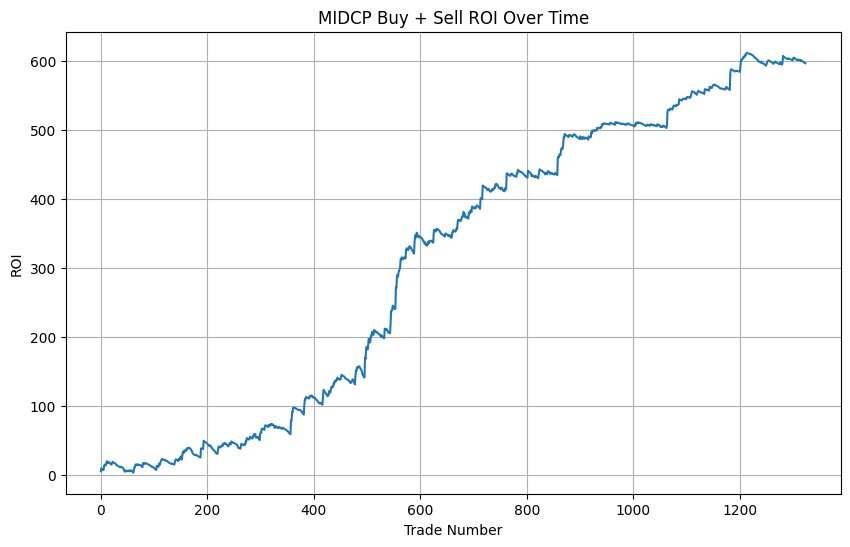

In [3074]:
import matplotlib.pyplot as plt

tradebook = both_indices_combined_tb

tradebook["Cumulative Returns"] = tradebook["ROI%"].cumsum()
plt.figure(figsize=(10, 6))
plt.plot(tradebook["Cumulative Returns"], linestyle="-")
plt.title("MIDCP Buy + Sell ROI Over Time")
plt.xlabel("Trade Number")
plt.ylabel("ROI")
plt.grid(True)
plt.show()

In [3075]:
tradebook

Signal Generated At Trade Type           Entry Time  Entry Price  \
0     2017-01-09 10:15:00       LONG  2017-01-09 11:15:00    8246.5500   
1     2017-01-11 10:15:00       LONG  2017-01-11 11:15:00   18670.8500   
2     2017-01-19 10:15:00       LONG  2017-01-19 11:15:00   19108.4000   
3     2017-01-20 10:15:00       LONG  2017-01-20 11:15:00   19010.5000   
4     2017-01-24 11:15:00       LONG  2017-01-24 12:15:00   18977.7500   
5     2017-01-24 12:15:00       LONG  2017-01-24 13:15:00    8445.3000   
6     2017-01-24 13:15:00       LONG  2017-01-24 14:15:00   19013.1500   
7     2017-01-24 14:15:00       LONG  2017-01-24 15:15:00    8476.1000   
8     2017-01-31 11:15:00       LONG  2017-01-31 12:15:00   19492.3000   
9     2017-01-31 15:15:00       LONG  2017-02-01 09:15:00   19543.4500   
10    2017-02-01 12:15:00       LONG  2017-02-01 13:15:00    8658.8000   
11    2017-02-01 12:15:00       LONG  2017-02-01 13:15:00   19941.7000   
12    2017-02-08 12:15:00       LONG  2017-02-08 13:15:00   20297.3000   
13    2017-02-08 14:15:00       LONG  2017-02-08 15:15:00   20300.1000   
14    2017-02-09 11:15:00       LONG  2017-02-09 12:15:00    8755.5500   
15    2017-02-09 11:15:00       LONG  2017-02-09 12:15:00   20108.3000   
16    2017-02-13 12:15:00       LONG  2017-02-13 13:15:00   20194.2000   
17    2017-02-13 13:15:00       LONG  2017-02-13 14:15:00    8803.8000   
18    2017-02-14 12:15:00       LONG  2017-02-14 13:15:00   20228.7500   
19    2017-02-17 10:15:00       LONG  2017-02-17 11:15:00    8836.8000   
20    2017-02-17 10:15:00       LONG  2017-02-17 11:15:00   20707.2000   
21    2017-02-20 09:15:00       LONG  2017-02-20 10:15:00   20560.8000   
22    2017-02-20 10:15:00       LONG  2017-02-20 11:15:00    8840.7000   
23    2017-02-27 10:15:00       LONG  2017-02-27 11:15:00   20730.3500   
24    2017-02-27 15:15:00       LONG  2017-02-28 09:15:00   20632.2500   
25    2017-02-28 11:15:00       LONG  2017-02-28 12:15:00    8894.5000   
26    2017-02-28 13:15:00       LONG  2017-02-28 14:15:00   20614.4000   
27    2017-03-01 11:15:00       LONG  2017-03-01 12:15:00    8936.7500   
28    2017-03-01 13:15:00       LONG  2017-03-01 14:15:00    8942.4500   
29    2017-03-06 09:15:00       LONG  2017-03-06 10:15:00    8960.2500   
30    2017-03-08 14:15:00       LONG  2017-03-08 15:15:00   20687.1500   
31    2017-03-09 10:15:00       LONG  2017-03-09 11:15:00   20705.3500   
32    2017-03-09 12:15:00       LONG  2017-03-09 13:15:00    8915.2000   
33    2017-03-09 13:15:00       LONG  2017-03-09 14:15:00   20697.8000   
34    2017-03-10 11:15:00       LONG  2017-03-10 12:15:00    8941.8000   
35    2017-03-14 10:15:00       LONG  2017-03-14 11:15:00   21180.8500   
36    2017-03-14 12:15:00       LONG  2017-03-14 13:15:00    9082.9000   
37    2017-03-14 15:15:00       LONG  2017-03-15 09:15:00    9091.9000   
38    2017-03-14 15:15:00       LONG  2017-03-15 09:15:00   21116.2000   
39    2017-03-17 11:15:00       LONG  2017-03-17 12:15:00   21179.3000   
40    2017-03-20 10:15:00       LONG  2017-03-20 11:15:00   21132.6000   
41    2017-03-21 12:15:00       LONG  2017-03-21 13:15:00    9105.9500   
42    2017-03-21 12:15:00       LONG  2017-03-21 13:15:00   21028.7000   
43    2017-03-21 14:15:00       LONG  2017-03-21 15:15:00   21027.6500   
44    2017-03-21 14:15:00       LONG  2017-03-21 15:15:00    9125.6500   
45    2017-03-22 11:15:00       LONG  2017-03-22 12:15:00   20863.7500   
46    2017-03-28 09:15:00       LONG  2017-03-28 10:15:00    9096.9000   
47    2017-03-28 10:15:00       LONG  2017-03-28 11:15:00   21228.6500   
48    2017-03-29 10:15:00       LONG  2017-03-29 11:15:00    9126.1000   
49    2017-03-29 15:15:00       LONG  2017-03-30 09:15:00    9153.1500   
50    2017-03-30 12:15:00       LONG  2017-03-30 13:15:00    9157.8500   
51    2017-03-30 14:15:00       LONG  2017-03-30 15:15:00    9181.6000   
52    2017-04-03 10:15:00       LONG  2017-04-03 11:15:00   21493.3500   
53    2017

In [3078]:
tradebook.to_csv("Combined TB MIDCP LS56 BNF L4 NF L5 MTrend v2.csv")

In [244]:
df1 = pd.read_csv("BNF Since 2012 JJMS MTrend.csv")
df2 = pd.read_csv("NIFTY Since 2012 JJMS MTrend.csv")

comb = pd.concat([df1, df2], ignore_index=True)

comb.head()

Unnamed: 0  Signal Generated At Trade Type           Entry Time  \
0           0  2012-01-11 10:15:00       LONG  2012-01-11 11:15:00   
1           1  2012-01-11 15:15:00       LONG  2012-01-12 09:15:00   
2           2  2012-01-16 11:15:00       LONG  2012-01-16 12:15:00   
3           3  2012-01-18 12:15:00       LONG  2012-01-18 13:15:00   
4           4  2012-01-19 10:15:00       LONG  2012-01-19 11:15:00   

   Entry Price  Initial SL  Final SL            Exit Time  Exit Price  \
0    8800.8000   8759.2000 8759.2000  2012-01-11 14:15:00   8759.2000   
1    8858.9500   8821.4500 8925.9750  2012-01-16 09:15:00   8880.5500   
2    8870.5500   8813.8500 8980.5778  2012-01-18 11:15:00   8951.7500   
3    8972.3500   8924.2500 8924.2500  2012-01-18 13:15:00   8924.2500   
4    9181.6000   9145.8000 9780.1778  2012-01-27 11:15:00   9756.8500   

   Points Captured  After Costs         PnL         Remarks   Qty Leverage  \
0         -41.6000     -43.3560 -49425.8400  Initial SL hit  1140       5x   
1          21.6000      19.8260  22304.3062         TSL Hit  1125       5x   
2          81.2000      79.4178  89344.9913         TSL Hit  1125       5x   
3         -48.1000     -49.8897 -55377.5226  Initial SL Hit  1110       5x   
4         575.2500     573.3562 627824.9897         TSL Hit  1095       5x   

     ROI%  Trade Year  Trade Month     DD%  
0 -1.9770        2012            1  0.0000  
1  0.8922        2012            1  0.0000  
2  3.5738        2012            1  0.0000  
3 -2.2151        2012            1 -2.2151  
4 25.1130        2012            1  0.0000

In [245]:
comb["Entry Time"] = pd.to_datetime(comb["Entry Time"])
comb = comb.sort_values(by="Entry Time")
comb.head()

Unnamed: 0  Signal Generated At Trade Type          Entry Time  \
1084           0  2012-01-06 13:15:00       LONG 2012-01-06 14:15:00   
1085           1  2012-01-09 10:15:00       LONG 2012-01-09 11:15:00   
0              0  2012-01-11 10:15:00       LONG 2012-01-11 11:15:00   
1              1  2012-01-11 15:15:00       LONG 2012-01-12 09:15:00   
2              2  2012-01-16 11:15:00       LONG 2012-01-16 12:15:00   

      Entry Price  Initial SL  Final SL            Exit Time  Exit Price  \
1084    4722.6500   4696.5000 4696.5000  2012-01-09 09:15:00   4696.5000   
1085    4715.5000   4701.7000 5112.3387  2012-01-30 14:15:00   5083.6500   
0       8800.8000   8759.2000 8759.2000  2012-01-11 14:15:00   8759.2000   
1       8858.9500   8821.4500 8925.9750  2012-01-16 09:15:00   8880.5500   
2       8870.5500   8813.8500 8980.5778  2012-01-18 11:15:00   8951.7500   

      Points Captured  After Costs         PnL         Remarks   Qty Leverage  \
1084         -26.1500     -27.0919 -57299.4002  Initial SL Hit  2115       5x   
1085         368.1500     367.1701 776564.7298         TSL Hit  2115       5x   
0            -41.6000     -43.3560 -49425.8400  Initial SL hit  1140       5x   
1             21.6000      19.8260  22304.3062         TSL Hit  1125       5x   
2             81.2000      79.4178  89344.9913         TSL Hit  1125       5x   

        ROI%  Trade Year  Trade Month    DD%  
1084 -2.2920        2012            1 0.0000  
1085 31.0626        2012            1 0.0000  
0    -1.9770        2012            1 0.0000  
1     0.8922        2012            1 0.0000  
2     3.5738        2012            1 0.0000

In [246]:
comb.loc[comb["Trade Year"] >= 2012, "Qty"] /= 2

/tmp/ipykernel_462373/1836691918.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1057.5 1057.5  570.  ...  105.    97.5   97.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  comb.loc[comb["Trade Year"] >= 2012, "Qty"] /= 2


In [247]:
comb["PnL"] = comb["After Costs"] * comb["Qty"]
comb["ROI%"] = comb["PnL"] * 100 / 2500000

In [249]:
comb["Cumulative ROI%"] = comb["ROI%"].cumsum()
comb["Running Max ROI%"] = comb["Cumulative ROI%"].cummax()
comb["Drawdown"] = comb["Cumulative ROI%"] - comb["Running Max ROI%"]
comb.head()

Unnamed: 0  Signal Generated At Trade Type          Entry Time  \
1084           0  2012-01-06 13:15:00       LONG 2012-01-06 14:15:00   
1085           1  2012-01-09 10:15:00       LONG 2012-01-09 11:15:00   
0              0  2012-01-11 10:15:00       LONG 2012-01-11 11:15:00   
1              1  2012-01-11 15:15:00       LONG 2012-01-12 09:15:00   
2              2  2012-01-16 11:15:00       LONG 2012-01-16 12:15:00   

      Entry Price  Initial SL  Final SL            Exit Time  Exit Price  \
1084    4722.6500   4696.5000 4696.5000  2012-01-09 09:15:00   4696.5000   
1085    4715.5000   4701.7000 5112.3387  2012-01-30 14:15:00   5083.6500   
0       8800.8000   8759.2000 8759.2000  2012-01-11 14:15:00   8759.2000   
1       8858.9500   8821.4500 8925.9750  2012-01-16 09:15:00   8880.5500   
2       8870.5500   8813.8500 8980.5778  2012-01-18 11:15:00   8951.7500   

      Points Captured  After Costs         PnL         Remarks       Qty  \
1084         -26.1500     -27.0919 -28649.7001  Initial SL Hit 1057.5000   
1085         368.1500     367.1701 388282.3649         TSL Hit 1057.5000   
0            -41.6000     -43.3560 -24712.9200  Initial SL hit  570.0000   
1             21.6000      19.8260  11152.1531         TSL Hit  562.5000   
2             81.2000      79.4178  44672.4956         TSL Hit  562.5000   

     Leverage    ROI%  Trade Year  Trade Month    DD%  Cumulative ROI%  \
1084       5x -1.1460        2012            1 0.0000          -1.1460   
1085       5x 15.5313        2012            1 0.0000          14.3853   
0          5x -0.9885        2012            1 0.0000          13.3968   
1          5x  0.4461        2012            1 0.0000          13.8429   
2          5x  1.7869        2012            1 0.0000          15.6298   

      Running Max ROI%  Drawdown  
1084           -1.1460    0.0000  
1085           14.3853    0.0000  
0              14.3853   -0.9885  
1              14.3853   -0.5424  
2              15.6298    0.0000

In [252]:
stats_df8 = pd.DataFrame(
    index=range(2012, 2025),
    columns=[
        "Total ROI",
        "Total Trades",
        "Win Rate",
        "Avg Profit% per Trade",
        "Avg Loss% per Trade",
        "Max Drawdown",
        "ROI/DD Ratio",
    ],
)
combined_df_sorted = comb
combined_df_sorted["Total ROI%"] = combined_df_sorted["ROI%"]
# Iterate over each year
for year in range(2012, 2025):
    # Filter trades for the current year
    year_trades = combined_df_sorted[(combined_df_sorted["Trade Year"] == year)]

    # Calculate total ROI
    total_roi = year_trades["Total ROI%"].sum()

    # Calculate total number of trades
    total_trades = len(year_trades)

    # Calculate win rate
    win_rate = (year_trades["Total ROI%"] > 0).mean() * 100

    # Calculate average profit per trade
    avg_profit = year_trades[year_trades["Total ROI%"] > 0]["Total ROI%"].mean()

    # Calculate average loss per trade
    avg_loss = year_trades[year_trades["Total ROI%"] < 0]["Total ROI%"].mean()

    # Calculate maximum drawdown
    max_drawdown = (
        year_trades["Total ROI%"].cumsum() - year_trades["Total ROI%"].cumsum().cummax()
    ).min()

    # Calculate ROI/DD ratio
    roi_dd_ratio = total_roi / abs(max_drawdown)

    # Store the statistics in the DataFrame
    stats_df8.loc[year] = [
        total_roi,
        total_trades,
        win_rate,
        avg_profit,
        avg_loss,
        max_drawdown,
        roi_dd_ratio,
    ]

# Calculate overall statistics
overall_total_roi = stats_df8["Total ROI"].sum()
overall_total_trades = stats_df8["Total Trades"].sum()
overall_win_rate = (combined_df_sorted["Total ROI%"] > 0).mean() * 100
overall_avg_profit = combined_df_sorted[combined_df_sorted["Total ROI%"] > 0][
    "Total ROI%"
].mean()
overall_avg_loss = combined_df_sorted[combined_df_sorted["Total ROI%"] < 0][
    "Total ROI%"
].mean()
overall_max_drawdown = (
    combined_df_sorted["Total ROI%"].cumsum()
    - combined_df_sorted["Total ROI%"].cumsum().cummax()
).min()
overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)

# Store the overall statistics in the DataFrame
stats_df8.loc["Overall"] = [
    overall_total_roi,
    overall_total_trades,
    overall_win_rate,
    overall_avg_profit,
    overall_avg_loss,
    overall_max_drawdown,
    overall_roi_dd_ratio,
]
stats_df8

Total ROI Total Trades Win Rate Avg Profit% per Trade  \
2012      76.4972          158  27.8481                3.9700   
2013      37.2766          138  23.9130                4.2144   
2014     127.4984          149  29.5302                4.6171   
2015      23.1528          131  25.9542                2.9153   
2016      22.2047          152  21.7105                3.5913   
2017      25.8692          189  28.5714                2.0034   
2018      43.1049          137  31.3869                2.4910   
2019      68.7364          132  28.0303                3.6179   
2020     168.5118          120  35.8333                5.8762   
2021      86.9386          142  28.8732                4.3289   
2022      49.5638          139  25.8993                3.9050   
2023      58.1040          143  32.8671                2.3494   
2024      -3.5786           74  21.6216                2.2433   
Overall  783.8797    1804.0000  27.9933                3.5659   

        Avg Loss% per Trade Max Drawdown ROI/DD Ratio  
2012                -0.8613     -20.4448       3.7416  
2013                -0.9695     -36.4665       1.0222  
2014                -0.7205     -13.8698       9.1925  
2015                -0.7832     -18.7007       1.2381  
2016                -0.8093     -24.2499       0.9157  
2017                -0.6098     -14.2085       1.8207  
2018                -0.6809     -16.7316       2.5763  
2019                -0.6856     -11.5623       5.9449  
2020                -1.0930     -14.5069      11.6160  
2021                -0.8965     -17.4085       4.9940  
2022                -0.8837     -21.9185       2.2613  
2023                -0.5450     -12.0072       4.8391  
2024                -0.6806     -11.3305      -0.3158  
Overall             -0.7828     -36.4665      21.4959